## Scenario 3:
A hospital has a large dataset of patient records, including information on demographics,
medical history, diagnoses, treatments, and outcomes. The hospital wants to use this data
to develop a machine learning model that can predict the risk of readmission for patients
after they are discharged from the hospital. Develop a ML solution for the aforesaid
prediction with an example Dataset.

In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.pipeline import make_pipeline

from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    mean_absolute_percentage_error,
    confusion_matrix,
    make_scorer,
    precision_score,
    recall_score,
    RocCurveDisplay,
    roc_auc_score,
    r2_score
)

In [25]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/DRDO assesment/hospital_readmissions.csv')
data

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,[80-90),14,77,1,30,0,0,0,Missing,Circulatory,Other,Circulatory,no,normal,no,no,yes
24996,[80-90),2,66,0,24,0,0,0,Missing,Digestive,Injury,Other,no,high,yes,yes,yes
24997,[70-80),5,12,0,6,0,1,0,Missing,Other,Other,Other,normal,no,no,no,yes
24998,[70-80),2,61,3,15,0,0,0,Family/GeneralPractice,Respiratory,Diabetes,Other,no,no,yes,yes,no


In [26]:
# categorical variable to numerical
binaryCols = ['change','diabetes_med','readmitted']
for i in binaryCols:
    data[i] = data[i].apply(lambda x: 0 if x == 'no' else 1)

In [27]:
# categorical variable to numerical
noNormalHighCols = ['glucose_test','A1Ctest']
le = LabelEncoder()
for i in noNormalHighCols:
    #df_all[i] = le.fit_transform(df_all[i])
    data[i+'_ind'] = data[i].apply(lambda x: 0 if x == 'no' else 1 if x == 'normal' else 2)

data['age_t'] = le.fit_transform(data['age'])

In [28]:
# Select columns
quantCols = data.select_dtypes(include=[int,float]).columns

# Create new DataFrame with selected columns
df_features = data[quantCols]

df_features

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,change,diabetes_med,readmitted,glucose_test_ind,A1Ctest_ind,age_t
0,8,72,1,18,2,0,0,0,1,0,0,0,3
1,3,34,2,13,0,0,0,0,1,0,0,0,3
2,5,45,0,18,0,0,0,1,1,1,0,0,1
3,2,36,0,12,1,0,0,1,1,1,0,0,3
4,1,42,0,7,0,0,0,0,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,14,77,1,30,0,0,0,0,0,1,0,1,4
24996,2,66,0,24,0,0,0,1,1,1,0,2,4
24997,5,12,0,6,0,1,0,0,0,1,1,0,3
24998,2,61,3,15,0,0,0,1,1,0,0,0,3


<Axes: title={'center': 'Correlation Matrix of Model Features'}>

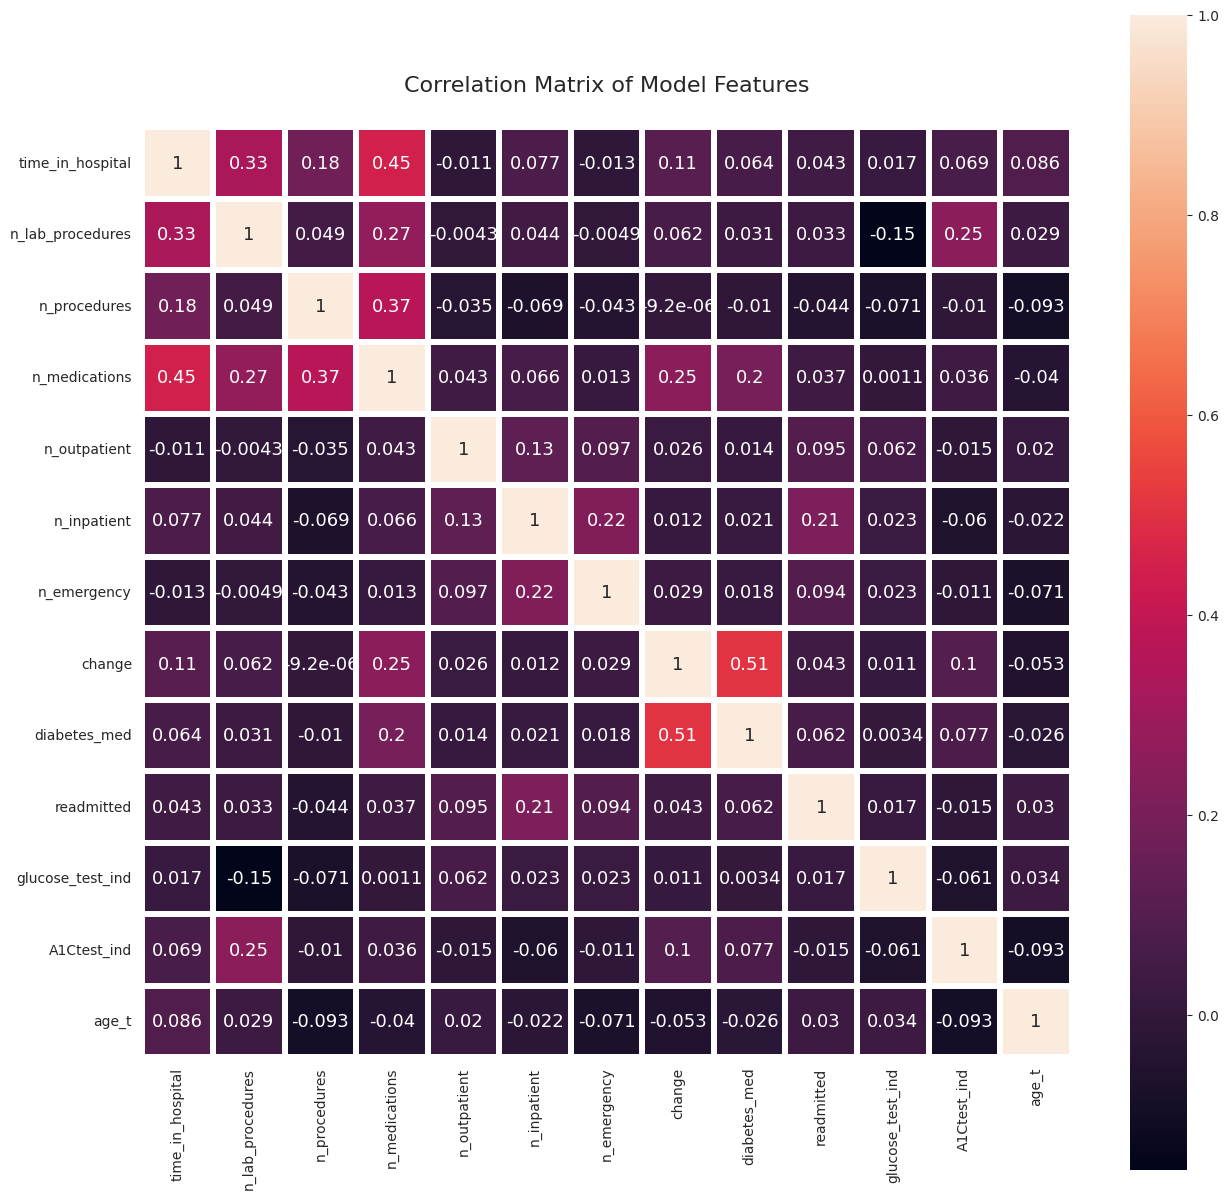

In [29]:
# correlation matrix
def corr_matrix(dataframe, x, y, title):
    plt.subplots(figsize=(x, y))
    plt.title(title, fontsize=16,y=1.03)
    return sns.heatmap(dataframe.corr(),
            annot=True,
            linewidths=3,
            annot_kws={"fontsize":13},
            square=True,
           )

corr_matrix(df_features, 15, 15, 'Correlation Matrix of Model Features')

In [30]:
#Transforming all colimns that have skewness
transformCols = ['time_in_hospital','n_lab_procedures','n_procedures',
                 'n_medications','n_outpatient','n_inpatient','n_emergency']
all([pd.api.types.is_numeric_dtype(df_features[col]) for col in transformCols])

True

In [31]:
df_log = df_features.copy()

# Perform a log transformation of the data to unskew the data
for feat in transformCols:
    #Add one to avoid INF values
    df_log[feat] = np.log(1+df_features[feat])

#Check how many INF readings we have in the data
np.isinf(df_log).sum()

time_in_hospital    0
n_lab_procedures    0
n_procedures        0
n_medications       0
n_outpatient        0
n_inpatient         0
n_emergency         0
change              0
diabetes_med        0
readmitted          0
glucose_test_ind    0
A1Ctest_ind         0
age_t               0
dtype: int64

In [32]:
#Change INF values to mean for each feature
for i in transformCols:
    df_log[i].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_log[i] = df_log[i].fillna(df_log[i].mean())

np.isinf(df_log).sum()

time_in_hospital    0
n_lab_procedures    0
n_procedures        0
n_medications       0
n_outpatient        0
n_inpatient         0
n_emergency         0
change              0
diabetes_med        0
readmitted          0
glucose_test_ind    0
A1Ctest_ind         0
age_t               0
dtype: int64

In [33]:
# Instialise StandardScaler, PCA
scaler = StandardScaler()
pca = PCA()

# Create the pipeline using scaler and the pca object
pipeline = make_pipeline(scaler, pca)

# Fit and transform the model
df_normalized = pipeline.fit_transform(df_log)
df_normalized.shape

(25000, 13)

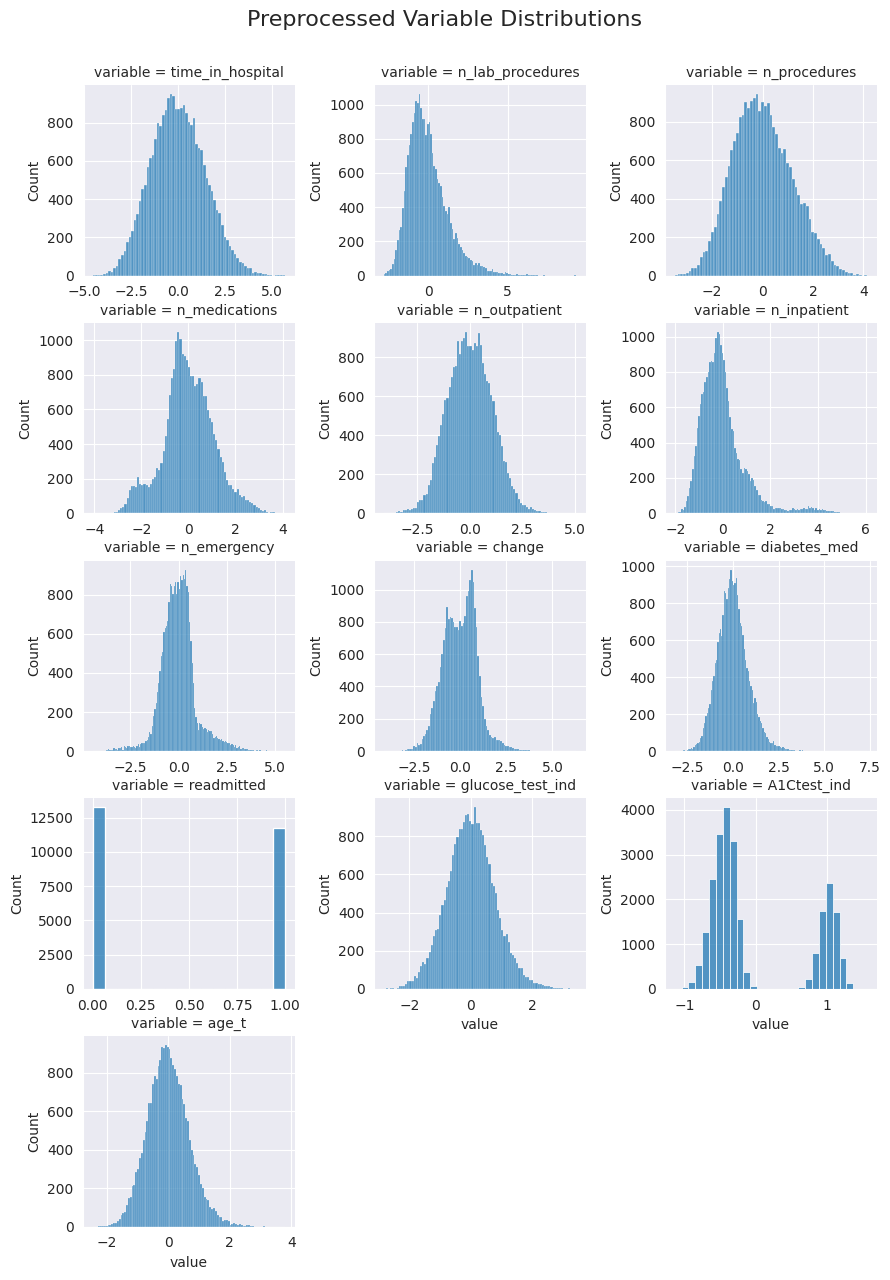

In [35]:
# Create a pandas DataFrame of the processed data
df_processed = pd.DataFrame(
    data=df_normalized, index=df_log.index, columns=df_log.columns
)


df_processed['readmitted'] = df_features['readmitted']

# Plot the distributions of the selected variables
g = sns.FacetGrid(df_processed.melt(),
                  col="variable",
                  col_wrap = 3,
                  sharey=False,
                  sharex=False
                 )
g.map(sns.histplot, "value")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Preprocessed Variable Distributions", fontsize=16,y=.85)
plt.show()

In [36]:
# Split the data into two DataFrames: X (features) and y (target variable)

X = df_processed.drop(columns=['readmitted'],axis=1)
y = df_processed["readmitted"]  # Specify one column as the target variable

# Split the data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.275, random_state=123
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18124, 12), (6876, 12), (18124,), (6876,))

In [37]:
y_train

15318    1
19189    0
8849     0
20370    0
22174    1
        ..
15377    0
21602    0
17730    0
15725    1
19966    0
Name: readmitted, Length: 18124, dtype: int64

In [38]:
# Define parameters
params = {
    "n_estimators": 97,  # Number of trees in the forest
    "max_depth": 10,  # Max depth of the tree
    "min_samples_split": 3,  # Min number of samples required to split a node
    "min_samples_leaf": 1,  # Min number of samples required at a leaf node
    "ccp_alpha": 0,  # Cost complexity parameter for pruning
    "random_state": 123,
}

rf = RandomForestClassifier(**params)

# Train the random forest on the train set
rf = rf.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = rf.predict(X_test)

In [39]:
y_pred = rf.predict(X_test)
print('Training Set:', rf.score(X_train,y_train))
print('Test Set:', rf.score(X_test,y_test))

# Calculate the accuracy, precision, and recall scores
print("Accuracy:", "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision:", "{:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall:", "{:.2f}%".format(recall_score(y_test, y_pred)*100))
print("Area Under the Curve:", "{:.2f}%".format(roc_auc_score(y_test, y_pred)*100))

#100% training set... Overfitted!

Training Set: 1.0
Test Set: 0.9978184991273996
Accuracy: 99.78%
Precision: 99.63%
Recall: 99.91%
Area Under the Curve: 99.79%


In [40]:
scores = cross_val_score(rf, X_test, y_test, error_score="raise", cv=5, verbose=True)
scores

array([0.99055233, 0.99490909, 0.99418182, 0.99709091, 0.99854545])

## Conclusion:
The model is overfitting as the test accuracy is 100%.
We can prevent overfitting by:
1. Reducing tree depth.
2. Using more data.
3. Hyperparameter tuning.

Due to time constraints, I was unable to put these suggestions into practice, but I will ultimately work on them and enhance the model's performance.